# Simulazioni RBM per la tesi magistrale

## Descrizione file
**Nome file:** esperimenti-tesi.ipynb  
**Autore:** Francesco Tosello  
**Contenuto:** Simulazioni numeriche per validare i risultati analitici ottenuti e descritti nella tesi.  

## Analisi e risultati

**Nota**: i parametri vanno accuratamente impostati a seconda della macchina sulla quale gira il programma.

### Intestazione

Caricamento del profilatore per il debugging

In [1]:
%load_ext line_profiler

Caricamento del modulo per le notifiche.

In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

Caricamento dei moduli necessari

In [25]:
import numpy as np
from numpy.linalg import norm
from scipy.optimize import root, minimize
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['text.usetex'] = True # serve per TeX
plt.rcParams['font.size'] = '19'

from auxcode.rbmstudy import calcola_cs_minimali, calcola_cs_q, calcola_cs_qhat, sol_nl, crit_threshold, estrazione_prob_inverso
from auxcode.utils import perturba_array, triu_to_axis
from auxcode.auxiliaryfun import nparam, dist_xis, genera_cfg_ortogonali

from time import process_time_ns
from datetime import datetime
from os.path import join

Impostazione dei colori

In [4]:
from colors.utils import load_cmap

In [5]:
SEQ_CMAP = 'orange-seq'
DIV_CMAP = 'blue-bordeaux-div'

In [6]:
seqcmap = load_cmap(SEQ_CMAP)
divcmap = load_cmap(DIV_CMAP)

Crea un generatore di numeri casuali

In [7]:
rng = np.random.default_rng()

### Soluzione delle equazioni nel caso di pattern ortogonali

Possiamo risolvere le equazioni stazionarie nello specifico di pattern originari ortogonali.
Qui sappiamo che in realtà le equazioni si possono ridurre di numero perché siamo sulla Linea di Nishimori.

In [8]:
def soluzione_autoconsistenze_minimali(iniz, beta, alpha, toll = 1e-4, metodo = 'diagbroyden'):
    
    def func(param):
        return param - np.concatenate((
            calcola_cs_minimali(param[2:4], 1, 1),
            calcola_cs_minimali(param[0:2], beta, alpha)
        ))
    
    res = root(func, iniz, tol = toll, method = metodo)
    
    return res.success, res.x, np.abs(func(res.x))

In [9]:
betas = np.logspace(-1, 0.7, num = 3) # va da 0.1 a 5
alpha_molt = np.geomspace(0.4, 1.4, num = 15) # prima calcola per questi alpha
astep = 1.5 # fattore moltiplicativo per ogni alpha successivo
maxalpha = 30 # massimo di punti che calcola
flagtol = 1e-2
amaxflag = 3 # punti con q decrescente dopo i quali si interrompe

sval = 0.95
iniz = perturba_array(rng, 1 - sval, np.array([sval]*4))

mres = []
alphas = []
for i,b in enumerate(betas):

    alphas.append([])
    res = None
    succs = np.zeros(0)
    
    j = 0
    flag = 0
    qprec = 0
    while j < maxalpha and (j < alpha_molt.size or flag < 2):
        if j < alpha_molt.size:
            amolt = alpha_molt[j]
        else:
            amolt *= astep
        alphas[i].append( amolt *np.float_power(b, -4) )
        try:
            suc, sol, val = soluzione_autoconsistenze_minimali(iniz, b, alphas[i][j])
        except (ZeroDivisionError, ValueError, OverflowError) as err:
            print(f"Errore nella ricerca degli zeri, beta = {b:.2f}, alpha = {alphas[i][j]:.2e}. Errore: {err}.")
            suc = False
            sol = np.full(iniz.size, np.nan)
            val = np.full(iniz.size, np.nan)
            
        succs = np.append(succs, suc)
        if res is None:
            res = np.atleast_2d(sol)
        else:
            res = np.vstack((res, sol))
        
        q = np.abs(sol[1])
        #print(f"{j}: exflag {flag} - {qprec:.5e}, {q:.5e}, {suc}.") # DEBUG
        if q <= (1 + flagtol) and q - qprec > 0:
            flag = 0
            qprec = q
        else:
            flag += 1
        
        j += 1
        
    print(f"Caso beta={b:.1f}, soluzioni calcolate con successo: {np.int_(np.sum(succs))}/{succs.size}.")
    
    mres.append(
        np.ma.array(res,
                    mask = np.broadcast_to((1 - succs).reshape(succs.size,1), (succs.size, res.shape[-1])) )
    )

Caso beta=0.1, soluzioni calcolate con successo: 9/10.
Caso beta=5.0, soluzioni calcolate con successo: 8/10.


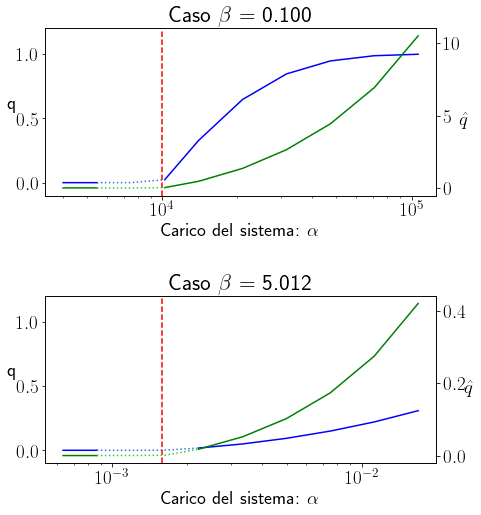

In [10]:
fig, axs = plt.subplots(betas.size, 1, figsize = (7, betas.size * 4))
glims = [-0.1, 1.2] # limiti dell'asse y per m,q: i risultati dovrebbero stare sotto 1

for i,b in enumerate(betas):
    alpha = np.array(alphas[i])
    
    axs[i].set_title(f"Caso $\\beta$ = {b:.3f}")
    axs[i].set_xlabel("Carico del sistema: $\\alpha$")
    axs[i].set_xscale('log')
    axs[i].axvline(x = np.float_power(b, -4), linestyle = '--', color = 'r')
    
    ax2 = axs[i].twinx()
    
    inv_idx = np.ones(alpha.size)
    for sl in np.ma.clump_masked(mres[i][:,0]):
        inv_idx[ range(*slice( max(sl.start-1,0), sl.stop+1 ).indices(alpha.size)) ] = 0
    invres = np.ma.array(mres[i].data, mask = 
                         np.broadcast_to(inv_idx.reshape(alpha.size,1), (alpha.size, mres[i].shape[-1])) )
    
    axs[i].set_ylabel('q', rotation = 0)
    axs[i].set_ylim(glims)
    axs[i].plot(alpha, mres[i][:,1], '-', color = 'blue')
    axs[i].plot(alpha, invres[:,1], ':', color = 'royalblue')
    #axs[i].plot(alpha, np.abs(mres[i][:,0]), '-', color = 'slateblue')
    #axs[i].plot(alpha, np.abs(invres[:,0]), ':', color = 'darkslateblue')
    
    
    ax2.set_ylabel('$\\hat{q}$', rotation = 0)
    ax2.plot(alpha, mres[i][:,3], '-', color = 'green')
    ax2.plot(alpha, invres[:,3], ':', color = 'limegreen')
    #ax2.plot(alpha, np.abs(mres[i][:,2]), '-', color = 'springgreen')
    #ax2.plot(alpha, np.abs(invres[:,2]), ':', color = 'palegreen')
    
fig.subplots_adjust(hspace = 0.6)

### Soluzione completa e con possibilità di ansatsz

In [11]:
def soluzione_autoconsistenze(P, iniz, beta, alpha, idx, mergesol, q = 0, toll = 1e-2, maxiter = 10):
    
    xis_dist = dist_xis(P, q)
    
    def autoconsistenze(params):
        q = calcola_cs_q(P, idx, params[params.size//2:], xis_dist)
        qhat = calcola_cs_qhat(P, idx, params[:params.size//2], xis_dist, beta, alpha)
        return params - mergesol(q,qhat)
    
    # Metodo di ricerca delle radici
    #res = root(autoconsistenze, iniz, method = 'diagbroyden', tol = toll, options = {'maxiter': maxiter})
    
    # Metodo che minimizza la norma localmente
    # NOTA: andrebbe usato un metodo di ricerca del minimo globale, non locale come minimize
    res = minimize(lambda par: norm(autoconsistenze(par)[:nparam(P)]), iniz,
                  bounds = tuple([(-1,+1)]*nparam(P) + [(None,None)]*nparam(P)),
                   tol = toll, options = {'maxiter': maxiter})
    
    # Minimizzazione della norma globalmente (NON ANCORA PRONTO)
    #res = basinhopping(lambda par: norm(autoconsistenze(par)[:nparam(P)]), iniz,
    #                  niter = maxiter, stepsize = 0.1)
    
    # vedi https://docs.scipy.org/doc/scipy/reference/optimize.html per altri metodi
    
    return res.success, res.x, np.abs(autoconsistenze(res.x))

In [12]:
%%notify

P = 2
maxit = 5

beta = 1
alphas = np.array([0.2, 0.4, 0.7, 1, 1.3, 1.5, 1.8, 2.1, 3]) * np.float_power(beta, -4)

q = 0.3

sval = 0.99
iniz = np.concatenate( sol_nl(P, *perturba_array(rng, 1 - sval, np.array([sval]*2))) )

# Condizioni complete, (5p-1)p
idx_full = np.full(nparam(P), True)
mergesol_full = lambda q,qhat: np.concatenate((q, qhat))

# Condizioni post prima transizione di fase: le sei matrici sono con tutti i valori uguali
#(ha senso solo per q diverso da 0)
#idx = np.zeros(nparam(P), dtype = bool)
#idx[[0, P**2, 2*(P**2)]] = True # calcola il primo parametro di ogni matrice
#mergesol = lambda q,qhat: np.concatenate(( q.repeat([P**2, P**2, P*(P-1)//2]), qhat.repeat([P**2, P**2, P*(P-1)//2]) ))


res = None
succs = np.array([])
for k,a in enumerate(alphas):
    
    try:
        startt = process_time_ns()
        suc, sol, val = soluzione_autoconsistenze(P, iniz, beta, a, idx_full, mergesol_full, q = q, maxiter = maxit)
    except (ValueError, ArithmeticError) as err:
        print(f"Errore nella ricerca delle radici per beta={beta:.1f}, alpha={a:.3E}.", err)
        suc = False
        sol = np.full(iniz.size, np.nan)
        val = np.full(iniz.size, np.nan)
    else:
        duration = process_time_ns() - startt
        print(f"Risultati calcolati per beta={beta:.1f}, alpha={a:.2E} in {duration/1e9:.1f}s.",
             f"Massimo errore {np.amax(val):.2E}.")
    
    succs = np.append(succs, suc)
    
    if res is None:
        res = np.atleast_2d(sol)
    else:
        res = np.vstack((res, sol))
        
mres = np.ma.array(res,
                   mask = np.broadcast_to((1 - succs).reshape(succs.size,1), (succs.size, res.shape[-1])) )
inv_idx = np.ones(alphas.size)
for sl in np.ma.clump_masked(mres[:,0]):
    inv_idx[ range(*slice( max(sl.start-1,0), sl.stop+1 ).indices(alphas.size)) ] = 0
invres = np.ma.array(mres.data,
                     mask = np.broadcast_to(inv_idx.reshape(alphas.size,1), (alphas.size, mres.shape[-1])) )

Errore nella ricerca delle radici per beta=1.0, alpha=2.000E-01. 
Errore nella ricerca delle radici per beta=1.0, alpha=1.400E+00. 


<IPython.core.display.Javascript object>

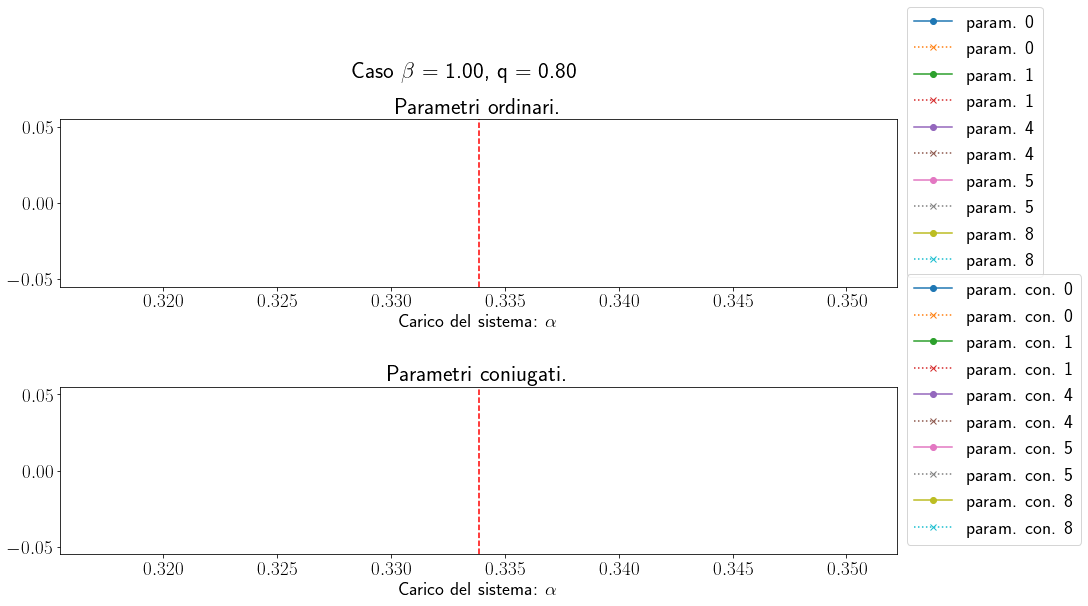

In [13]:
fig, axs = plt.subplots(2, 1, figsize = (15, 8))

fig.subplots_adjust(hspace = 0.6)
fig.suptitle(f"Caso $\\beta$ = {beta:.2f}, q = {q:.2f}")

for i in range(2):
    axs[i].set_xlabel("Carico del sistema: $\\alpha$")
    #axs[i].set_xscale('log')
    thr = crit_threshold(beta, dist_xis(P, q))
    axs[i].axvline(x = thr, linestyle = '--', color = 'r')

axs[0].set_title(f"Parametri ordinari.")
axs[1].set_title(f"Parametri coniugati.")

plt_idx = [0,1,4,5,8]
for j in range(mres.shape[1]//2): # parametri
    if j in plt_idx:
        # non serve che metto mres perché tanto è vuoto
        axs[0].plot(alphas, mres[:,j], 'o-', label = f'param. {j}')
        axs[0].plot(alphas, invres[:,j], 'x:', label = f'param. {j}')
        axs[1].plot(alphas, mres[:,j+mres.shape[1]//2], 'o-', label = f'param. con. {j}')
        axs[1].plot(alphas, invres[:,j+mres.shape[1]//2], 'x:', label = f'param. con. {j}')

axs[0].legend(loc='lower left', bbox_to_anchor = (1, 0));
axs[1].legend(loc='lower left', bbox_to_anchor = (1, 0));

### Simulazione Monte Carlo del problema di inferenza

In [14]:
%%notify

N = 1200
P = 1
beta = 1.5
betainv = beta
alphas = np.geomspace(0.5, 4, 10) * np.float_power(beta, -4)
# Indicativamente vorrei almeno che: N * min(alphas) * beta^(-4) > 30
steps = 10*N
nrep = 10 # numero di repliche da calcolare

xis = genera_cfg_ortogonali(N, P, met = 'rnd' if N > 8 else 'ord')

extxis = estrazione_prob_inverso(rng, N, alphas, P, xis, beta, betainv = betainv, num = nrep, steps = steps)

Attenzione! Numero di esempi basso: 10, con beta=1.5, alpha=0.10 e N=100.


<IPython.core.display.Javascript object>

In [15]:
qs = np.abs( np.sum(xis[np.newaxis, np.newaxis :, np.newaxis, :] * extxis[:, :, np.newaxis, :, :],
                       axis = -1)/N ) # overlap vero-replica
app = np.argmax(qs, axis = 2) # indice di appaiamento
qu = np.abs( np.sum(
    triu_to_axis(extxis[..., :, np.newaxis, :] * extxis[..., np.newaxis, :, :], axis = -3, k = 1),
    axis = -1)/N ) # overlap replica[i]-replica[i]
qd = np.abs( np.sum(
    triu_to_axis(extxis[:, [0], :, np.newaxis, :] * extxis[:, 1:, np.newaxis, :, :], axis = -3, k = 0),
    axis = -1)/N ) # overlap replica[0]-replica[i], i > 1

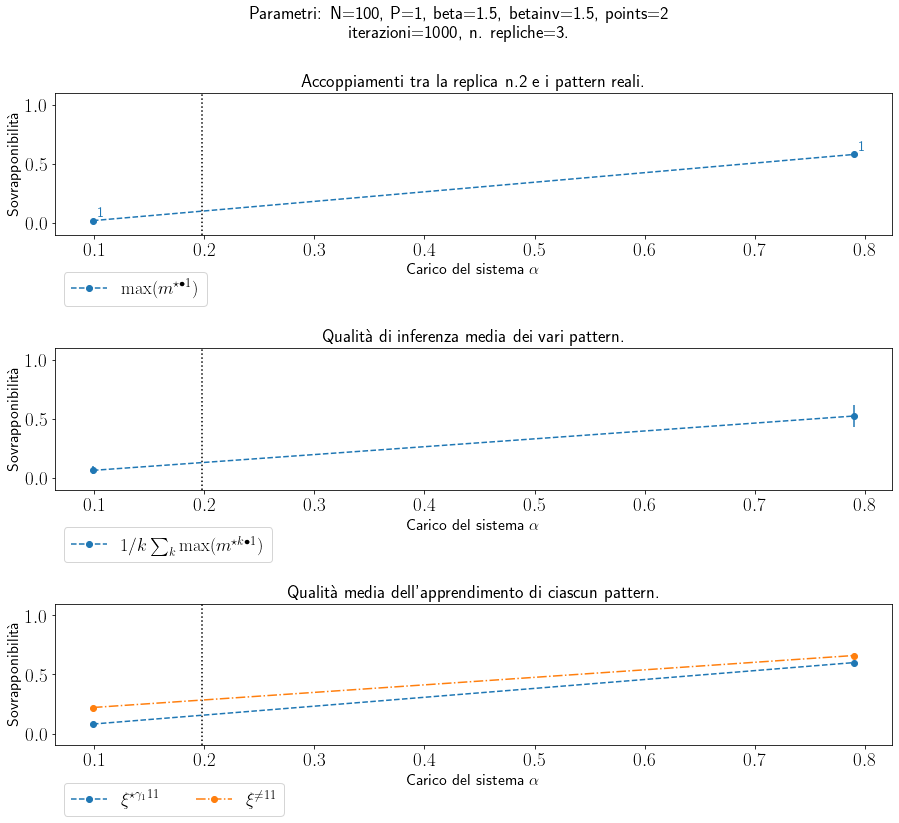

In [16]:
nplots = 3 # HARDCODED!

fig, axs = plt.subplots(nplots, 1, figsize = (15, 4 * nplots))
fig.suptitle(f"Parametri: N={N}, P={P}, beta={beta}, betainv={betainv}, points={alphas.size}\n"
             + f"iterazioni={steps}, n. repliche={nrep}.",
            fontsize = 18)
fig.subplots_adjust(hspace = 0.8)

for j in range(nplots):
    axs[j].set_xlabel("Carico del sistema $\\alpha$", fontsize = 16)
    #axs[j].set_xscale('log')
    
    axs[j].set_ylabel("Sovrapponibilità", fontsize = 16)
    axs[j].set_ylim([-0.1, 1.1])
    
    axs[j].axvline(x = np.float_power(beta, -4), linestyle = ':', color = 'k')

    
# Primo grafico per capire come evolve l'accoppiamento di ciascun pattern con quelli originali
# Prova che la scelta del pattern al quale appaiarsi è casuale
r = rng.integers(0, nrep, 1)[0] # prendi una replica a caso

axs[0].set_title(f"Accoppiamenti tra la replica n.{r+1} e i pattern reali.", fontsize = 18)

lines, labels = [], []

argmaxq = app[:, r, :]
maxq = np.amax(qs[:, r, ...], axis = 1) # è più facile così che calcolare qs in argmaxq

lines += axs[0].plot(alphas, maxq, 'o--')
labels += [ "$\\max(m^{\star \\bullet " + str(x+1) + "})$" for x in range(P) ]
for a, mu in itertools.product(range(qs.shape[0]), range(qs.shape[-1])):
    axs[0].annotate(f"{argmaxq[a, mu] + 1}", (alphas[a], maxq[a,mu]), fontsize = 14, textcoords = 'offset pixels',
                   xytext = (5, 14 * (0.3 - mu)), color = lines[mu].get_color())
#sumq = np.sum(qs[:, j, ...], axis = 1)
#lines += axs[0].plot(alphas, sumq, 'x', linestyle = lstyles[j])
#labels += [ "$\\sum_{\mu} \\xi^{\star " + f"\gamma_{j+1} " + "\\mu " + str(x+1) + "})$" for x in range(P) ]

axs[0].legend(lines, labels, fontsize = 18, bbox_to_anchor = (0, -0.2), loc = 'upper left', ncol = 5)


# Secondo grafico per capire quanto riesco a inferire (andamento accoppiamenti medi)
# Verifico che tutte le sinapsi migliorino e con lo stesso andamento (nessuna asimmetria)
axs[1].set_title(f"Qualità di inferenza media dei vari pattern.", fontsize = 18)

lines, labels = [], []

maxq = np.amax(qs, axis = -2) # è più facile così che calcolare qs in argmaxq
for p in range(P):
    ebarres = axs[1].errorbar(alphas, maxq[...,p].mean(axis = 1), yerr = maxq[...,p].std(axis = 1), fmt = 'o--')
    lines += [ebarres.lines[0]]
    labels += [ "$1/k \\sum_{k} \\max(m^{\star k \\bullet " + str(p+1) + "})$" ]
#sumq = np.sum(qs[:, j, ...], axis = 1)
#lines += axs[0].plot(alphas, sumq, 'x', linestyle = lstyles[j])
#labels += [ "$\\sum_{\mu} \\xi^{\star " + f"\gamma_{j+1} " + "\\mu " + str(x+1) + "})$" for x in range(P) ]

axs[1].legend(lines, labels, fontsize = 18, bbox_to_anchor = (0, -0.2), loc = 'upper left', ncol = 5)


# Terzo grafico per valutare se tutti i pattern originari vengono appresi con la stessa facilità
axs[2].set_title(f"Qualità media dell'apprendimento di ciascun pattern.", fontsize = 18)

lines, labels = [], []
for p in range(P):
    
    # Forse devi usare
    #  qs.transpose((0,1,3,2))[tuple(np.ogrid[[slice(0, end) for end in qs.shape[:-1]]] + [app])]
    lines += axs[2].plot(alphas, qs[:,0,...].reshape(alphas.size, -1), 'o--')
    labels += [ "$\\xi^{\star" + "\gamma_1" + str(i+1) + " " + str(x+1) + "}$" 
             for i,x in itertools.product(*[range(P)]*2) ]
    lines += axs[2].plot(alphas, qu[:,0,...], 'o-.') if qu.shape[2] >= 1 else []
    labels += [ "$\\xi^{= " + str(i+1) + " " + str(x+1) + "}$" for i,x in itertools.product(*[range(P)]*2) if i > x ]
    lines += axs[2].plot(alphas, qd[:,0,...], 'o-.')
    labels += [ "$\\xi^{\\neq " + str(i+1) + " " + str(x+1) + "}$" for i,x in itertools.product(*[range(P)]*2) if i >= x ]

axs[2].legend(lines, labels, fontsize = 18, bbox_to_anchor = (0, -0.2), loc = 'upper left', ncol = 6)

### Analisi della soglia critica

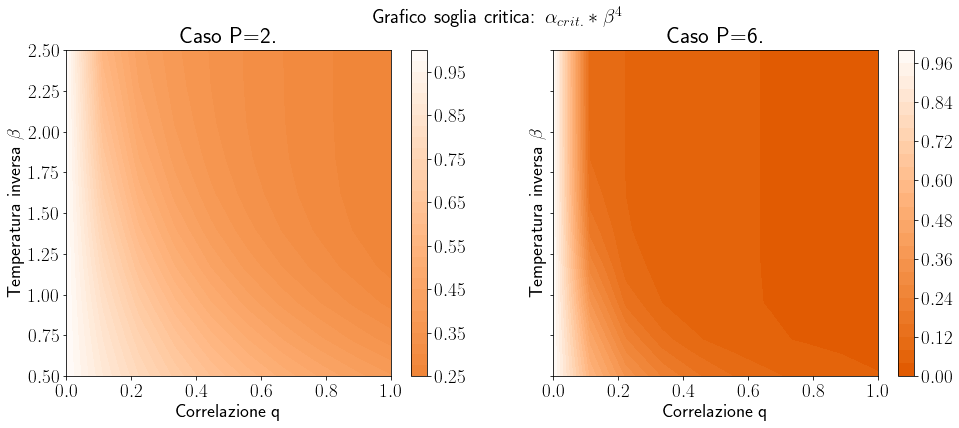

In [17]:
Ps = np.array([2, 6])
zmin, zmax = 0.001, 1.001

qp, bp = 25, 25
ptsq = np.linspace(0, 1, qp)
ptsb = np.linspace(0.5, 2.5, bp)

fig, ax = plt.subplots(1, Ps.size, figsize = (16, 6), sharex = True, sharey = True)
fig.suptitle("Grafico soglia critica: $\\alpha_{crit.} * \\beta^4$", fontsize = 20)

for j in range(Ps.size):
    ax[j].set_title(f"Caso P={Ps[j]}.")
    ax[j].set_xlabel("Correlazione q")
    ax[j].set_ylabel("Temperatura inversa $\\beta$")
    jplot = ax[j].contourf(ptsq, ptsb, 
                 np.reshape( np.vectorize(lambda q,b:b**4 * crit_threshold(b, dist_xis(Ps[j], q)))(
                     *(c.flatten() for c in np.meshgrid(ptsq,ptsb))), (qp, bp) ),
                           levels = 30, vmin = zmin, vmax = zmax, cmap = seqcmap
                )
    fig.colorbar(jplot, ax = ax[j])

plt.show()

In [18]:
qp = np.linspace(0, 1, 4)
ppts = np.array([2, 4, 6])

idxp = 1
idxq = 2

tp = np.linspace(0.1, 1.5, 50)
alphas = np.vectorize( 
    lambda q,p,b: crit_threshold(b, dist_xis(p, q)) )( *(c.flatten() for c in np.meshgrid(qp,ppts,1/tp, indexing = 'ij')) ).reshape(
    qp.size, ppts.size, tp.size)

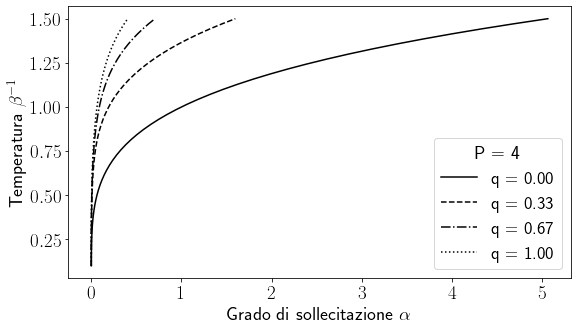

In [19]:
fig = plt.figure()
ax = fig.gca()

ax.set_xlabel("Grado di sollecitazione $\\alpha$")
ax.set_ylabel("Temperatura $\\beta^{-1}$")

linest = ['-', '--', '-.', ':']
for i,q in enumerate(qp):
    ax.plot(alphas[i, idxp, :], tp, label = f"q = {q:.2f}", linestyle = linest[i], c = 'k')
ax.legend(fontsize = 18, title = f"P = {ppts[idxp]}")

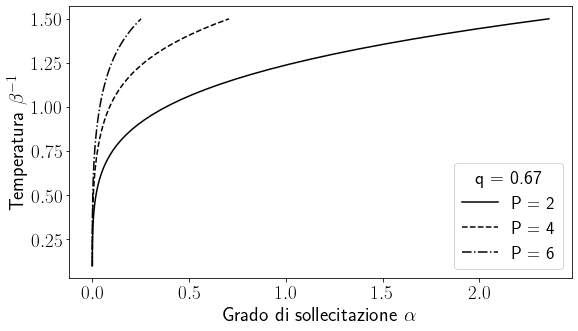

In [20]:
fig = plt.figure()
ax = fig.gca()

ax.set_xlabel("Grado di sollecitazione $\\alpha$", fontsize = 20)
ax.set_ylabel("Temperatura $\\beta^{-1}$", fontsize = 20)

linest = ['-', '--', '-.', ':']
for i,p in enumerate(ppts):
    ax.plot(alphas[idxq, i, :], tp, label = f"P = {p}", linestyle = linest[i], c = 'k')
ax.legend(fontsize = 18, title = f"q = {qp[idxq]:.2f}")

### Confronto MonteCarlo e Autoconsistenze

In [21]:
# Parametri condivisi
beta = 0.5
alphas = np.geomspace(0.7, 4, num = 7) * np.float_power(beta, -4)

# Parametri per le autoconsistenze
sval = 0.95

# Parametri per il Monte Carlo
N = 80 # MULTIPLO DI 4!
Ps = np.array([1, 2, 3])
betainv = beta
# Indicativamente vorrei almeno che: N * min(alphas) * beta^(-4) > 30
steps = 30*N
nrep = 200 # numero di repliche da calcolare

In [22]:
iniz = perturba_array(rng, 1 - sval, np.array([sval]*4))

res = None
succs = np.zeros(0)

for j, alpha in enumerate(alphas):
    try:
        suc, sol, val = soluzione_autoconsistenze_minimali(iniz, beta, alpha)
    except (ZeroDivisionError, ValueError, OverflowError) as err:
        print(f"Errore nella ricerca degli zeri, alpha = {alpha:.2e}. Errore: {err}.")
        suc = False
        sol = np.full(iniz.size, np.nan)
        val = np.full(iniz.size, np.nan)

    succs = np.append(succs, suc)
    if res is None:
        res = np.atleast_2d(sol)
    else:
        res = np.vstack((res, sol))

mres = np.ma.array(res, mask = np.broadcast_to((1 - succs).reshape(succs.size,1), (succs.size, res.shape[-1])) )

In [23]:
%%notify

qs = []
app = []
for i,P in enumerate(Ps):
    xis = genera_cfg_ortogonali(N, P, met = 'rnd', rng = rng)
    extxis = estrazione_prob_inverso(rng, N, alphas, P, xis, beta, betainv = betainv, num = nrep, steps = steps,
                                     debug = True)
    qs.append( np.abs( np.sum(xis[np.newaxis, np.newaxis :, np.newaxis, :] * extxis[:, :, np.newaxis, :, :],
                       axis = -1)/N ) ) # overlap vero-replica
    app.append( np.argmax(qs[i], axis = 2) ) # indice di appaiamento

Calcolate n.3 repliche di MH con 400 iterazioni per alpha=1.12e+01 e P=1 in 0.3s.
Calcolate n.3 repliche di MH con 400 iterazioni per alpha=6.40e+01 e P=1 in 0.7s.
Calcolate n.3 repliche di MH con 400 iterazioni per alpha=1.12e+01 e P=2 in 0.3s.
Calcolate n.3 repliche di MH con 400 iterazioni per alpha=6.40e+01 e P=2 in 0.7s.


<IPython.core.display.Javascript object>

In [26]:
filen = "risultati/confronto-mc-cstaz_" + datetime.strftime(datetime.now(), "%m%d-%H%M") + f"_{int(beta*100):03d}"

np.savez_compressed(filen, *qs, *app, beta = beta, alphas = alphas, sval = sval, N = N, Ps = Ps,
                   betainv = betainv, steps = steps, nrep = nrep, iniz = iniz, mres = mres)

Parametri: N=80, beta=0.5, betainv=0.5, points=7
iterazioni=2400, n. repliche=200.
Parametri: N=200, beta=0.8, betainv=0.8, points=7
iterazioni=4000, n. repliche=50.
Parametri: N=400, beta=1.2, betainv=1.2, points=7
iterazioni=8000, n. repliche=50.


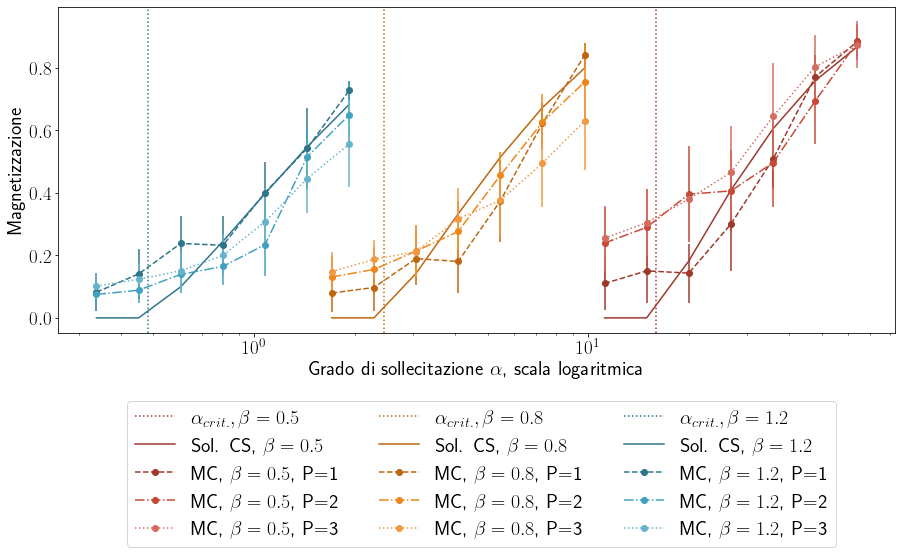

In [27]:
DIR = "risultati/"

filess = ['confronto-mc-cstaz_1212-2043_050.npz',
          'confronto-mc-cstaz_1212-1751_080.npz',
          'confronto-mc-cstaz_1212-1711_120.npz']

colors = np.array([[[157, 56, 43], [200, 72, 55], [211, 108, 95]],
                   [[190, 102, 14],[238,134,27],  [241, 153, 65]],
                   [[46, 116, 138],[64, 162, 191],[102, 180, 204]]])/255


fig = plt.figure(figsize = (15,6))
ax = fig.gca()

ax.set_xlabel("Grado di sollecitazione $\\alpha$, scala logaritmica", fontsize = 20)
ax.set_xscale('log')
ax.set_ylabel("Magnetizzazione", fontsize = 20)

lines, labels = [], []

for i,f in enumerate(filess):
    datas = np.load(join(DIR,f))

    print(f"Parametri: N={datas['N']}, beta={datas['beta']}, betainv={datas['betainv']},"
          + f" points={datas['alphas'].size}\n"
            + f"iterazioni={datas['steps']}, n. repliche={datas['nrep']}.")
    
    lines += [ax.axvline(x = np.float_power(datas['beta'], -4), linestyle = ':', color = tuple(colors[i,0]))]
    labels += [f"$\\alpha_{{crit.}}, \\beta={datas['beta']:.1f}$"]

    lines += ax.plot(datas['alphas'], datas['mres'][:,1], '-', color = tuple(colors[i,0])) 
    labels += [f"Sol. CS, $\\beta={datas['beta']:.1f}$"]
    
    formats = ['o--', 'o-.', 'o:']
    for k,P in enumerate(datas['Ps']):
        maxq = np.amax(datas['arr_' + str(k)], axis = -2) # è più facile così che calcolare qs in argmaxq
        lines += [ ax.errorbar(datas['alphas'], maxq[...,0].mean(axis = 1), yerr = maxq[...,0].std(axis = 1), 
                                  fmt = formats[k], color = tuple(colors[i,k])).lines[0] ]
        labels += [ f"MC, $\\beta={datas['beta']:.1f}$, P={P}" ]

lgd = ax.legend(lines, labels, fontsize = 20, bbox_to_anchor = (0.07, -0.18), loc = 'upper left', ncols = 3)

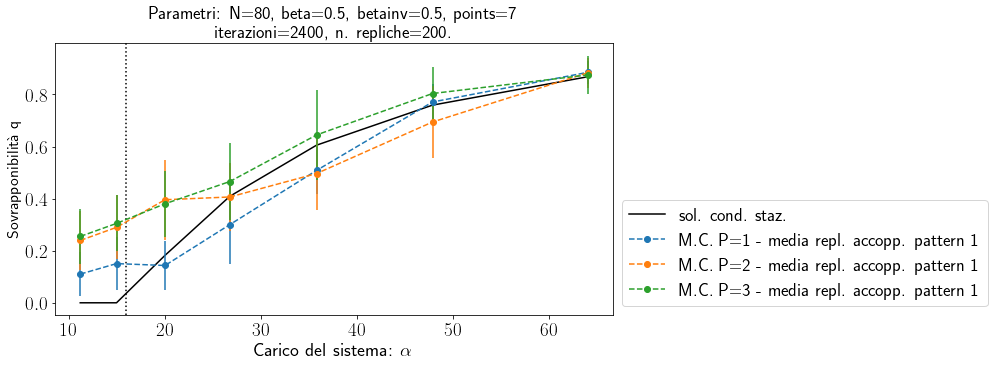

In [28]:
datas = np.load(join(DIR,filess[0]))

fig = plt.figure(figsize = (10, 5))
ax = plt.gca()
ax.set_title(f"Parametri: N={datas['N']}, beta={datas['beta']}, betainv={datas['betainv']}, points={datas['alphas'].size}\n"
             + f"iterazioni={datas['steps']}, n. repliche={datas['nrep']}.",
            fontsize = 18)

ax.set_xlabel("Carico del sistema: $\\alpha$")
#ax.set_xscale('log')
ax.set_ylabel("Sovrapponibilità q", fontsize = 16)
ax.axvline(x = np.float_power(datas['beta'], -4), linestyle = ':', color = 'k')

lines, labels = [], []

lines += ax.plot(datas['alphas'], datas['mres'][:,1], '-', color = 'k')
labels += ["sol. cond. staz."]

# Secondo grafico per capire quanto riesco a inferire (andamento accoppiamenti medi)
for i,P in enumerate(datas['Ps']):
    maxq = np.amax(datas['arr_' + str(i)], axis = -2) # è più facile così che calcolare qs in argmaxq
    lines += [ ax.errorbar(datas['alphas'], maxq[...,0].mean(axis = 1), yerr = maxq[...,0].std(axis = 1), fmt = 'o--').
              lines[0] ]
    labels += [ f"M.C. P={P} - media repl. accopp. pattern 1" ]

ax.legend(lines, labels, fontsize = 18, bbox_to_anchor = (1, 0), loc = 'lower left')